In [26]:
import datetime
import json
import boto3
import io
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
#import seaborn as sns
plt.style.use('ggplot')

In [2]:
pickle_file = '../btc-autotrader/lib/data/log/2019-03-11T19:00:26.203575.pickle'

In [3]:
df = pd.read_pickle(pickle_file)

In [4]:
df['spread'] = df.ask_low - df.bid_high

In [5]:
df['spread_pct_change'] = df.spread.pct_change()

In [22]:
df.loc[df.rate_of_change >= 0, 'rate_of_change_positive'] = 1
df.loc[df.rate_of_change < 0, 'rate_of_change_positive'] = -1
df.loc[df.rate_of_change >= 5, 'rate_of_change_positive'] = 2
df.loc[df.rate_of_change < -5, 'rate_of_change_positive'] = -2

In [27]:
df['btc_current_price_normalized'] = (df.btc_current_price - df.btc_current_price.mean()) / df.btc_current_price.std()


In [28]:
df.tail()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,ask_low,bought_price,sold_price,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized
0,2019-03-12 04:55:46.852824,41273.0,41273.0,0.016221,427264.0,BUYING,-0.529675,0,-0.00212422,427061.0,427264.0,0,0,0,203.0,-0.024038,-1.0,-0.724100
0,2019-03-12 04:55:56.784499,41273.0,41273.0,0.016221,427264.0,BUYING,-0.529675,0,0,427061.0,427261.0,0,0,0,200.0,-0.014778,-1.0,-0.724100
0,2019-03-12 04:56:06.923644,41273.0,41273.0,0.016221,427259.0,BUYING,-0.534274,0,-0.000453549,426931.0,427256.0,0,0,0,325.0,0.625000,-1.0,-0.727585
0,2019-03-12 04:56:16.854171,41273.0,41273.0,0.016221,427259.0,BUYING,-0.534274,0,0,426934.0,427262.0,0,0,0,328.0,0.009231,-1.0,-0.727585
0,2019-03-12 04:56:25.864620,41273.0,41273.0,0.016221,427259.0,BUYING,-0.534274,0,0,426795.0,427257.0,0,0,0,462.0,0.408537,-1.0,-0.727585


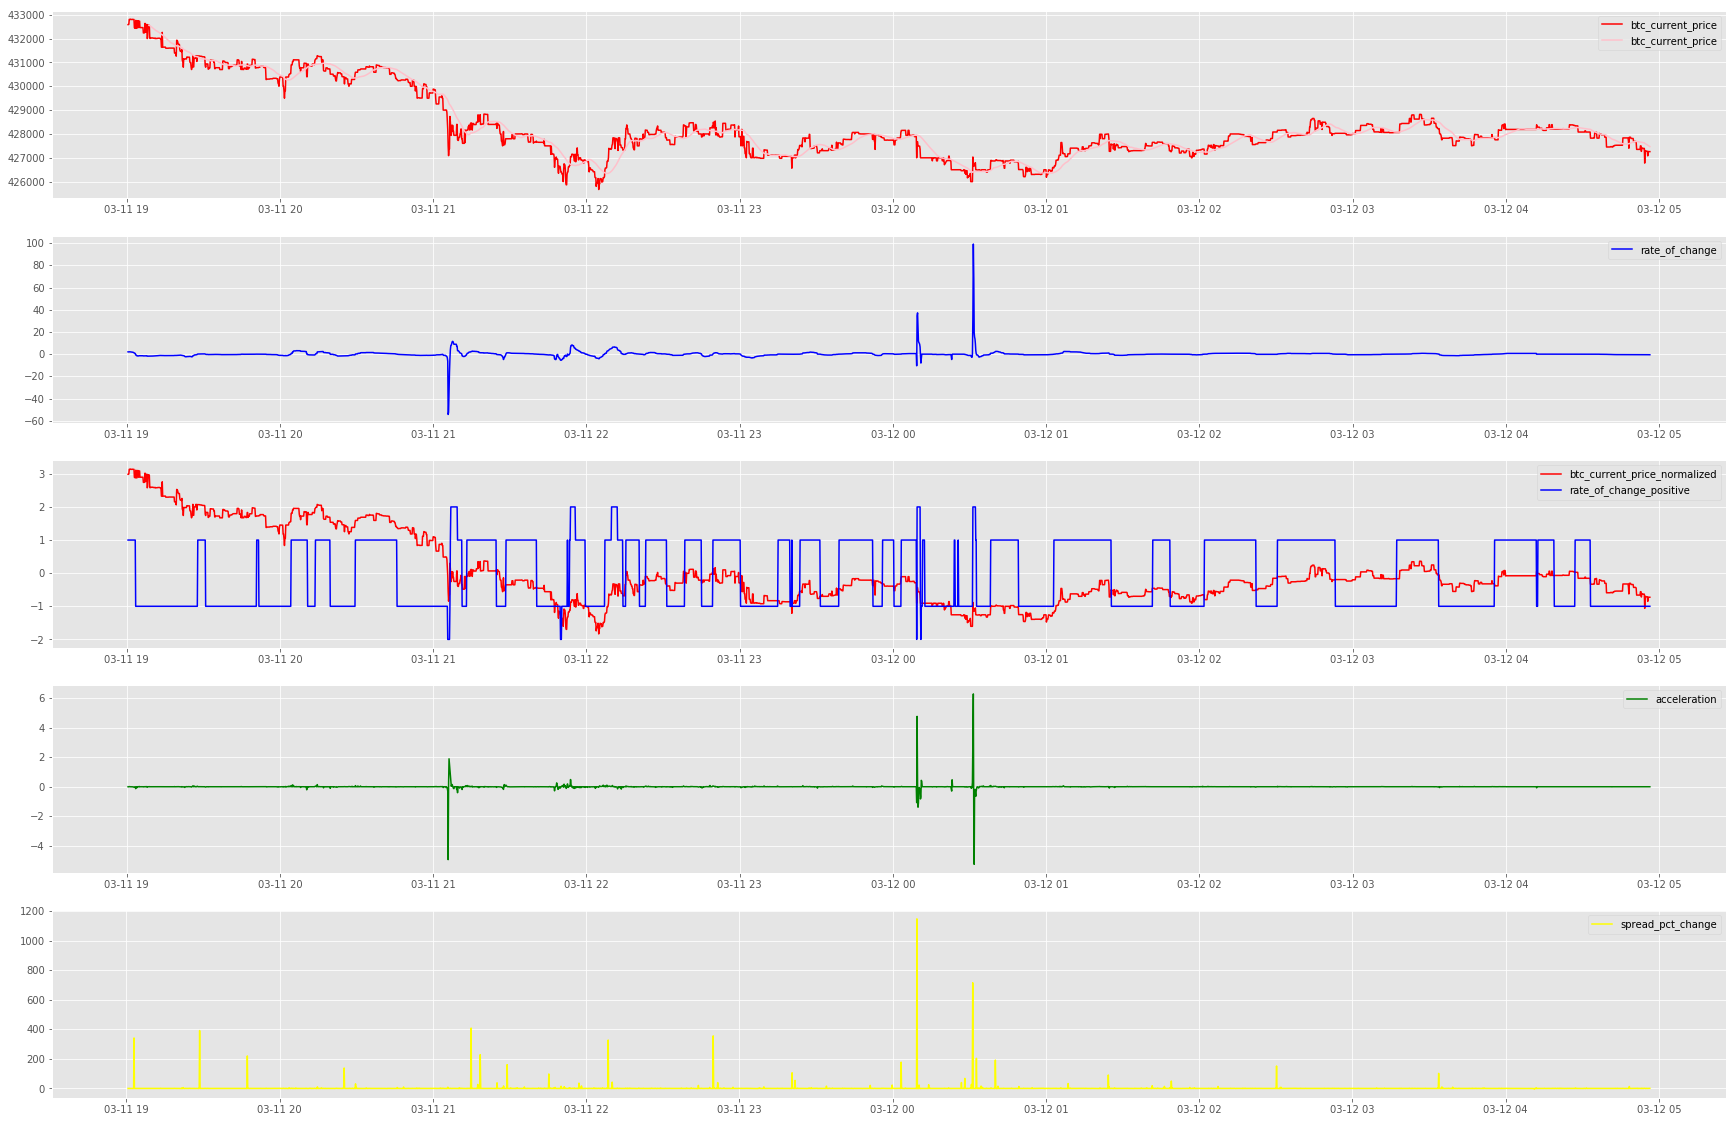

In [31]:
num = 5
fig, axes = plt.subplots(nrows=num, ncols=1, figsize=(30, 20), sharex=True)
plt.subplot(num,1,1)
plt.plot(df.datetime, df.btc_current_price, color='r')
plt.plot(df.datetime, df.btc_current_price.rolling(50).mean(), color='pink')
plt.legend()
#ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
#ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
plt.subplot(num,1,2)
plt.plot(df.datetime, df.rate_of_change, color='b')
plt.legend()
plt.subplot(num,1,3)
plt.plot(df.datetime, df.btc_current_price_normalized, color='r')
plt.plot(df.datetime, df.rate_of_change_positive, color='b')
plt.legend()
plt.subplot(num,1,4)
plt.plot(df.datetime, df.acceleration, color='g')
#plt.yscale('log')
plt.legend()
plt.subplot(num,1,5)
plt.plot(df.datetime, df.spread_pct_change, color='yellow')
plt.legend()
#plt.plot(df.datetime, df.spread_pct_change())
plt.show()

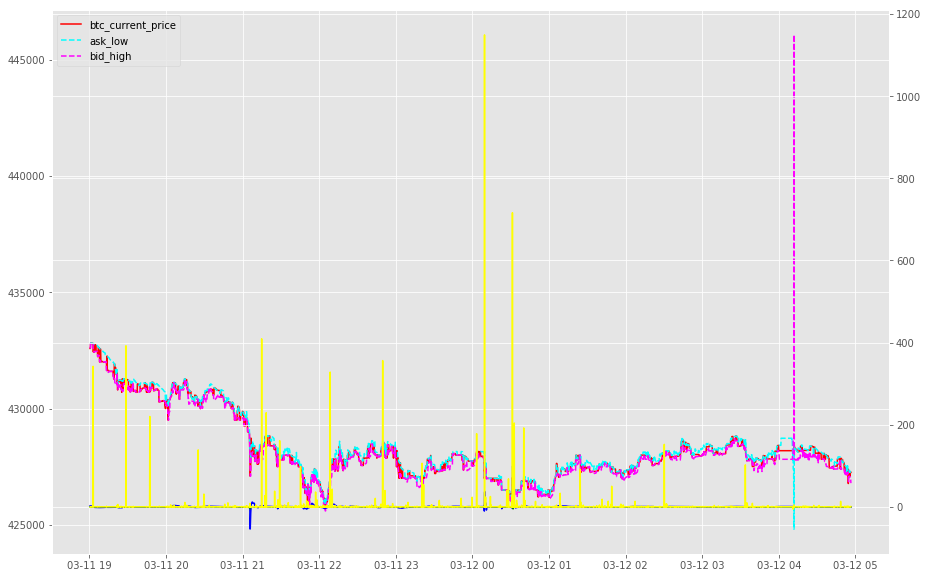

In [8]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.btc_current_price, color='r')
ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
ax1.legend()
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
#ax2.legend()
plt.show()

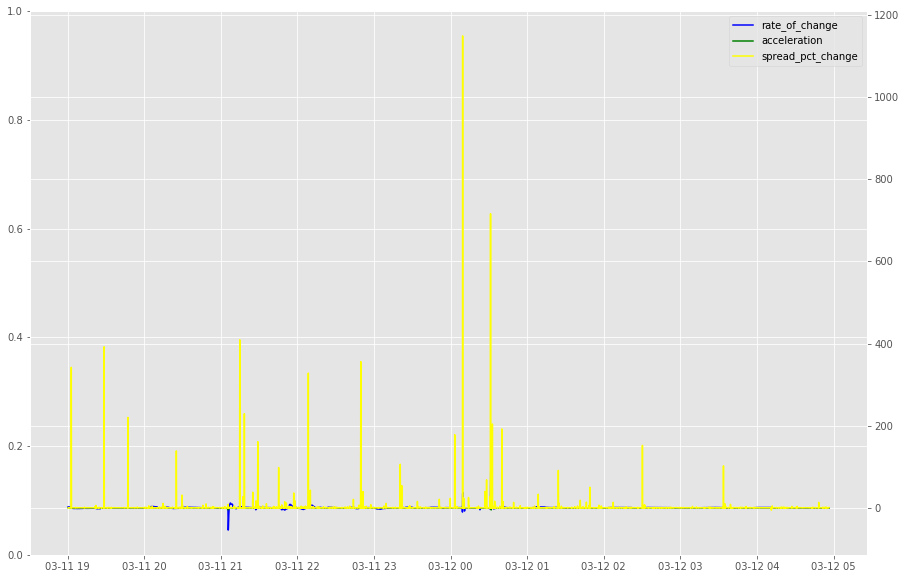

In [9]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
#ax1.plot(df.datetime, df.btc_current_price, color='r')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
ax2.legend()
plt.show()

In [10]:
df.total_value.iloc[-1] - df.total_value.iloc[0]

0

No handles with labels found to put in legend.


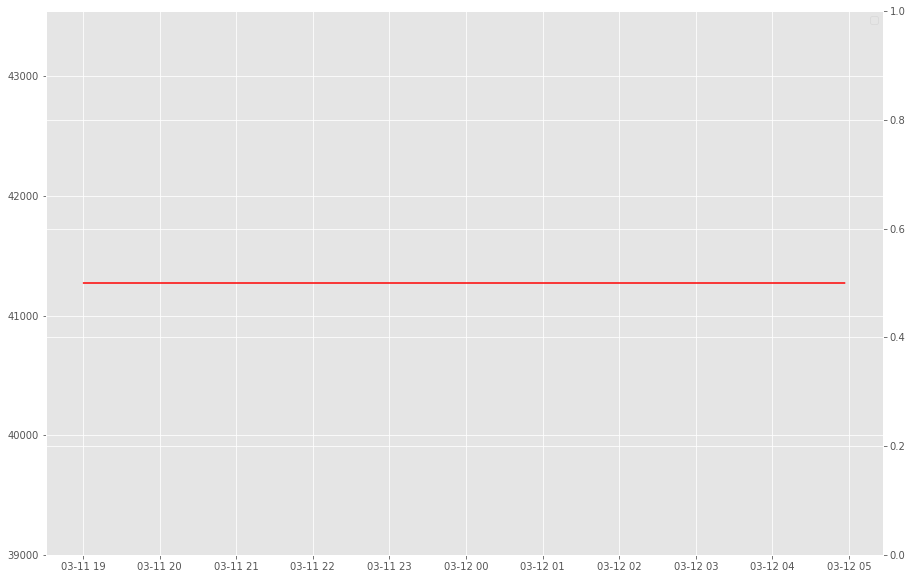

In [11]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.cash, color='r')
#ax2.plot(df.datetime, df.rate_of_change, color='b')
#ax2.plot(df.datetime, df.acceleration, color='g')
ax2.legend()
plt.show()